### make data

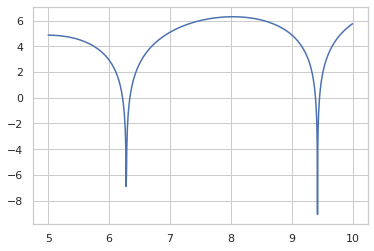

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
x = np.linspace(5, 10, 1000)
y = np.log(np.sin(x) * np.cos(x) * (-2*x + x**2 + x**3 + 3) * np.tan(x))
plt.plot(x, y)

### split data

In [48]:
np.floor(validation_split * dataset_size)

200.0

In [2]:
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
shuffle_dataset = 1
validation_split = .2

dataset_size = len(x)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(99)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [3]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(x, batch_size=100, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(x, batch_size=100, sampler=valid_sampler)

### model

In [70]:
class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features=100, out_features=2**15),
            nn.ReLU(),
            nn.Linear(in_features=2**15, out_features=1)
        )
    
    def forward(self, x):
        x = self.fc(x)
        return x        

In [73]:
net = simpleNet()
criterion, optimizer = nn.MSELoss(), optim.Adam(net.parameters(), lr = 1e-7)
running_loss = .0
losses = []
val_losses = []

for epoch in range(100):
    net.train()
    total_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()

        label = y[train_indices[batch_idx*100 : (batch_idx+1)*100]]
        data = torch.tensor(data, dtype=torch.float)
        label = torch.tensor(label, dtype=torch.float)
        
        data = Variable(data, requires_grad=True)
        label = Variable(label, requires_grad=True)
        
        output = net(data).view(-1)
        loss = criterion(output, label)
        total_loss += loss
        loss.backward()
        optimizer.step()
        print('train loss', loss)
    losses.append(total_loss/len(train_loader))
    
    net.eval()
    val_total_loss = 0
    for batch_idx, data in enumerate(validation_loader):
        optimizer.zero_grad()
        data = torch.tensor(data, dtype=torch.float)
        label = y[val_indices[batch_idx*100 : (batch_idx+1)*100]]
        label = torch.tensor(label, dtype=torch.float)

        outputs = net(data).view(-1)
        loss = criterion(outputs, label)
        val_total_loss += loss
        loss.backward()
        optimizer.step()
        print('val loss', loss)
    val_losses.append(val_total_loss/len(validation_loader))


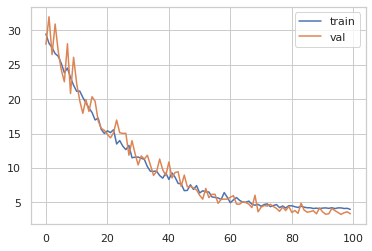

In [64]:
%matplotlib inline
plt.plot(losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()